In [50]:
%pylab notebook
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

Populating the interactive namespace from numpy and matplotlib


/Users/adityarotti/Library/Enthought/Canopy/edm/envs/User/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [51]:
pathout = "../figures/" + "global_data_compression/"
! mkdir $pathout

mkdir: ../figures/global_data_compression/: File exists


In [52]:
h=6.62607004e-34 #Plancks constant #m2 kg / s
k=1.38064852e-23 #Boltzmann constant #m2 kg s-2 K-1

def mbb(nu,T,A,alpha,nu0=1.):
    x=h*nu*1e9/(k*T)
    Inu=A*((nu/nu0)**alpha)*(nu**3.)/(exp(x)-1.)
    return Inu

def multitemp_mbb_spectra(nu,T1,A1,alpha1,T2,A2,alpha2,nu0=1.):
    Inu=mbb(nu,T1,A1,alpha1,nu0=nu0) + mbb(nu,T2,A2,alpha2,nu0=nu0)
    return Inu

In [53]:
h=6.62607004e-34 #Plancks constant #m2 kg / s
k=1.38064852e-23 #Boltzmann constant #m2 kg s-2 K-1

# Moment expansion for a modified black body spectra
def y1(x):
    return x*exp(x)/(exp(x)-1.)

def y2(x):
    return y1(x)*x*cosh(0.5*x)/sinh(0.5*x)

def y3(x):
    return y1(x)*x*x*(cosh(x)+2)/(cosh(x)-1)

def y4(x):
    return y2(x)*0.5*x*x*(cosh(x)+5)/(sinh(0.5*x)**2.)

def y5(x):
    return y1(x)*(x**4.)*(33.+26*cosh(x)+cosh(2.*x))/(8.*sinh(0.5*x)**4.)

def I0(nu,T,alpha,A):
    x=h*nu*1e9/k/T
    nu0=k*T/h/1e9
    return A*(((nu/nu0)**alpha)*(nu**3.))/(exp(x)-1.)

def f_mbb(nu,T,alpha,A,p22,p23,p33,p222,p223,p233,p333):
    x=h*nu*1e9/k/T
    nu0=k*T/h/1e9
    I0=A*(((nu/nu0)**alpha)*(nu**3.))/(exp(x)-1.)
    temp=I0*(1. + 0.5*p22*(log(nu/nu0))**2. + p23*log(nu/nu0)*y1(x)+ 0.5*p33*y2(x))
    temp = temp +  I0*(p222*(log(nu/nu0)**3.)/6. + 0.5*p223*(log(nu/nu0)**2.)*y1(x) + 0.5*p233*log(nu/nu0)*y2(x) + p333*y3(x)/6.)
    return temp

# Generating the distribution of parameters

1.0 12.9898662496 270.664805898


<IPython.core.display.Javascript object>


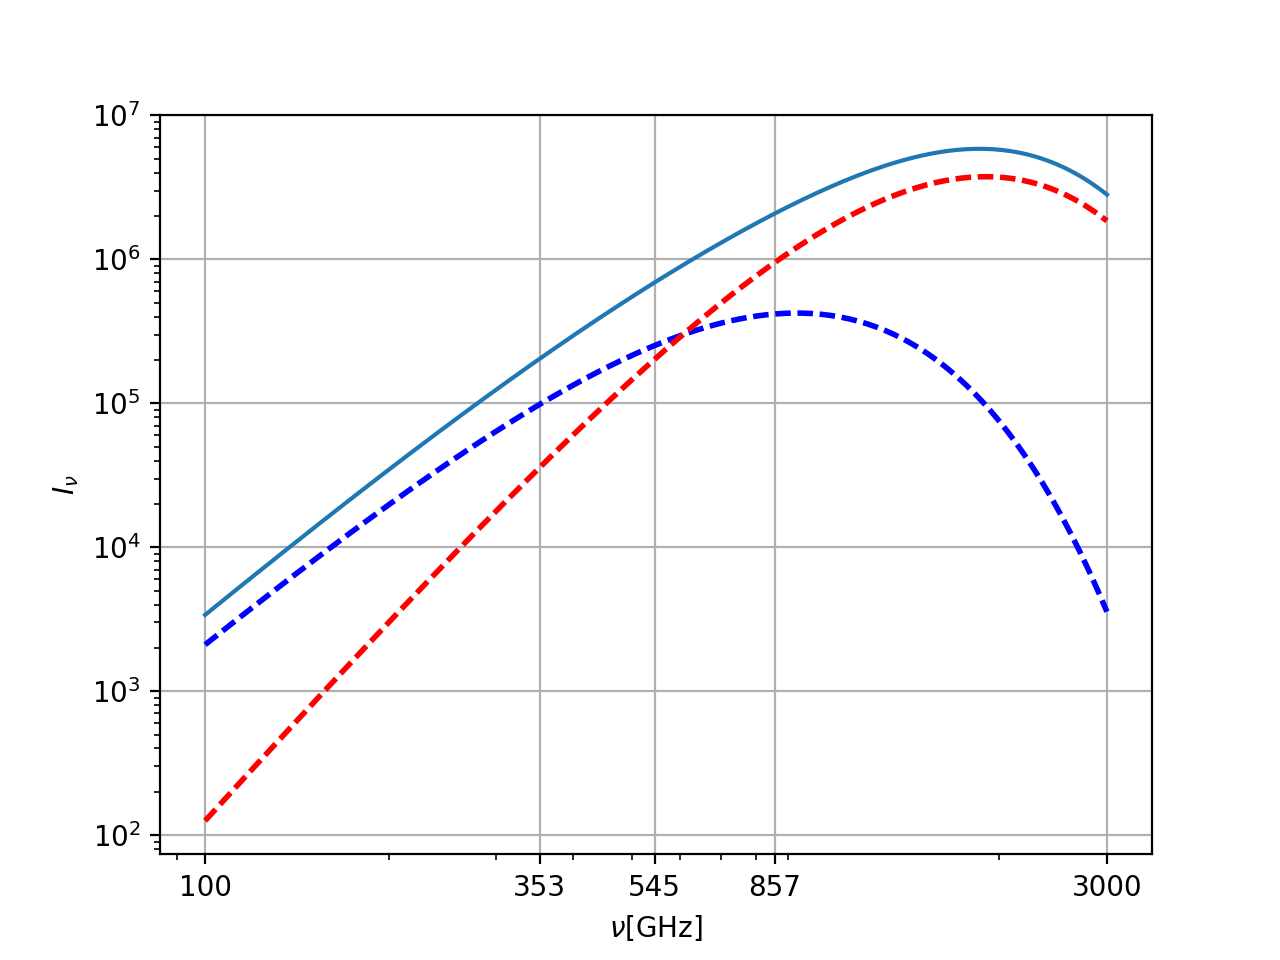

([<matplotlib.axis.XTick at 0x13b8057d0>,
 <a list of 5 Text xticklabel objects>)

In [75]:
f=0.34188
T1=9.75 ; A1=f; alpha1=1.63; T2=15.7 ; A2 =(1.-f); alpha2=2.82
#T1=12.75 ; A1=f; alpha1=1.63; T2=15.7 ; A2 =(1.-f); alpha2=2.82

Abar=A1+A2
Tbar=Abar/((A1/T1)+(A2/T2))
nu0=k*Tbar/h/1e9
print Abar,Tbar,nu0

nu=logspace(log10(100),log10(3000),200)
Inu=multitemp_mbb_spectra(nu,T1,A1,alpha1,T2,A2,alpha2,nu0=3000.)

Inu=Inu*3388/Inu[nu==100]
#nu=nu[nu>=300] ; Inu=Inu[nu>=300]

figure()
plot(nu,Inu)
plot(nu,mbb(nu,T1,A1,alpha1,nu0=3000.),"b--",lw=2)
plot(nu,mbb(nu,T2,A2,alpha2,nu0=3000.),"r--",lw=2)
loglog()
ylabel(r"$I_{\nu}$")
xlabel(r"$\nu$[GHz]")
grid()
legend(loc=0)
xticks([100,353,545,857,3000],[100,353,545,857,3000])

# Fitting the moments of the distribution

In [76]:
p0=(30.,0.,1e-6)
lb0=(0., -3.,0.) ; ub0=(100,3.,10.)
fitp0, fitcov0=curve_fit(I0, nu,Inu,p0,bounds=(lb0,ub0),maxfev=200000)
print fitp0

[  1.84517942e+01   1.81945280e+00   6.39219664e-03]


<IPython.core.display.Javascript object>


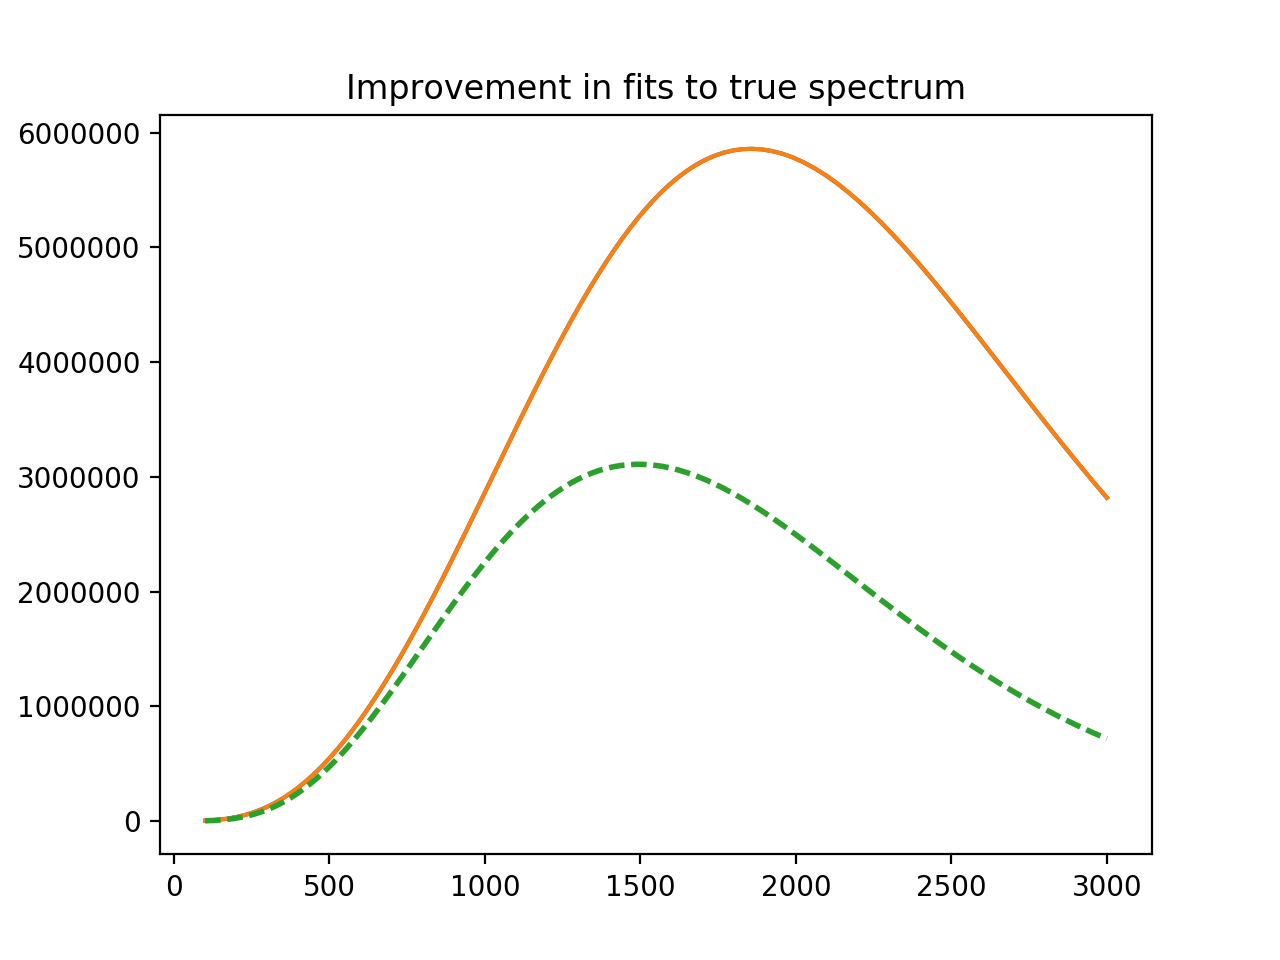

<IPython.core.display.Javascript object>


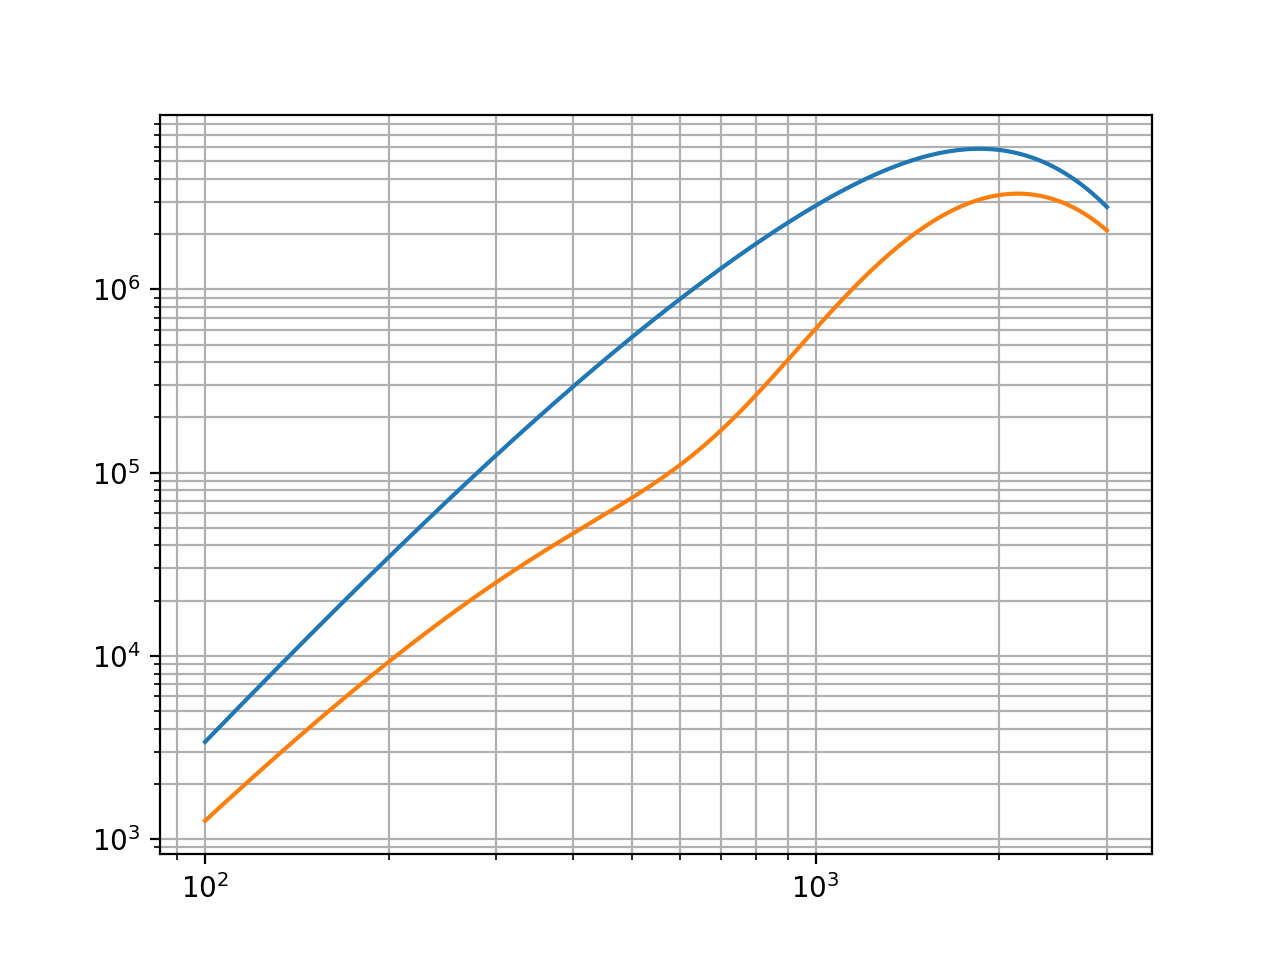

In [79]:
fitp0[0]=15.

figure()
title("Improvement in fits to true spectrum")
pllabel="Model SED"
plot(nu,Inu,label=pllabel)
pllabel="0 order (3 params.)"
plot(nu,Inu)
plot(nu,I0(nu,T=fitp0[0],alpha=fitp0[1], A=fitp0[2]),"--",lw=2)


figure()
plot(nu,Inu)
plot(nu,abs(Inu-I0(nu,T=fitp0[0],alpha=fitp0[1], A=fitp0[2])))
loglog()
grid(which="both")

In [80]:
def f_mbb1(nu,p2,p3):
    T=fitp0[0] ; alpha=fitp0[1] ; A=fitp0[2]
    x=h*nu*1e9/k/T
    nu0=k*T/h/1e9
    I0=A*(((nu/nu0)**alpha)*(nu**3.))/(exp(x)-1.)
    temp=I0*(1. + p2*(log(nu/nu0)) + p3*y1(x))
    return temp

def f_mbb2(nu,p2,p3,p22,p23,p33):
    T=fitp0[0] ; alpha=fitp0[1] ; A=fitp0[2]
    x=h*nu*1e9/k/T
    nu0=k*T/h/1e9
    I0=A*(((nu/nu0)**alpha)*(nu**3.))/(exp(x)-1.)
    temp=I0*(1. + p2*(log(nu/nu0)) + p3*y1(x))
    temp=temp+I0*(0.5*p22*(log(nu/nu0))**2. + p23*log(nu/nu0)*y1(x)+ 0.5*p33*y2(x))
    return temp

def f_mbb3(nu,p2,p3,p22,p23,p33,p222,p223,p233,p333):
    T=fitp0[0] ; alpha=fitp0[1] ; A=fitp0[2]
    x=h*nu*1e9/k/T
    nu0=k*T/h/1e9
    I0=A*(((nu/nu0)**alpha)*(nu**3.))/(exp(x)-1.)
    temp=I0*(1. + p2*(log(nu/nu0)) + p3*y1(x))
    temp=temp+I0*(0.5*p22*(log(nu/nu0))**2. + p23*log(nu/nu0)*y1(x)+ 0.5*p33*y2(x))
    temp = temp +  I0*(p222*(log(nu/nu0)**3.)/6. + 0.5*p223*(log(nu/nu0)**2.)*y1(x) + 0.5*p233*log(nu/nu0)*y2(x) + p333*y3(x)/6.)
    return temp

In [81]:
prange=2.

p0=(0.,0.)
lb1=[-prange,-prange]
ub1=[prange,prange]
fitp1, fitcov1=curve_fit(f_mbb1, nu,Inu,p0,bounds=[lb1,ub1],maxfev=200000)
print fitp1

p0=zeros(5,float)
lb2=ones(5,float)*(-prange)
ub2=ones(5,float)*(prange)
fitp2, fitcov2=curve_fit(f_mbb2, nu,Inu,p0,bounds=[lb2,ub2],maxfev=200000)
print fitp2

p0=zeros(9,float)
lb3=ones(9,float)*(-prange)
ub3=ones(9,float)*(prange)
fitp3, fitcov3=curve_fit(f_mbb3, nu,Inu,p0,bounds=[lb3,ub3],maxfev=200000)
print fitp3

[-1.84829952  0.73794662]
[-0.54751509  0.13902351 -0.06055826  0.09641138  0.01923134]
[-1.47285362  0.0510967  -0.08226255  0.66954271  0.09965167 -0.68870551
 -0.55677629  0.02475124 -0.00495088]


<IPython.core.display.Javascript object>


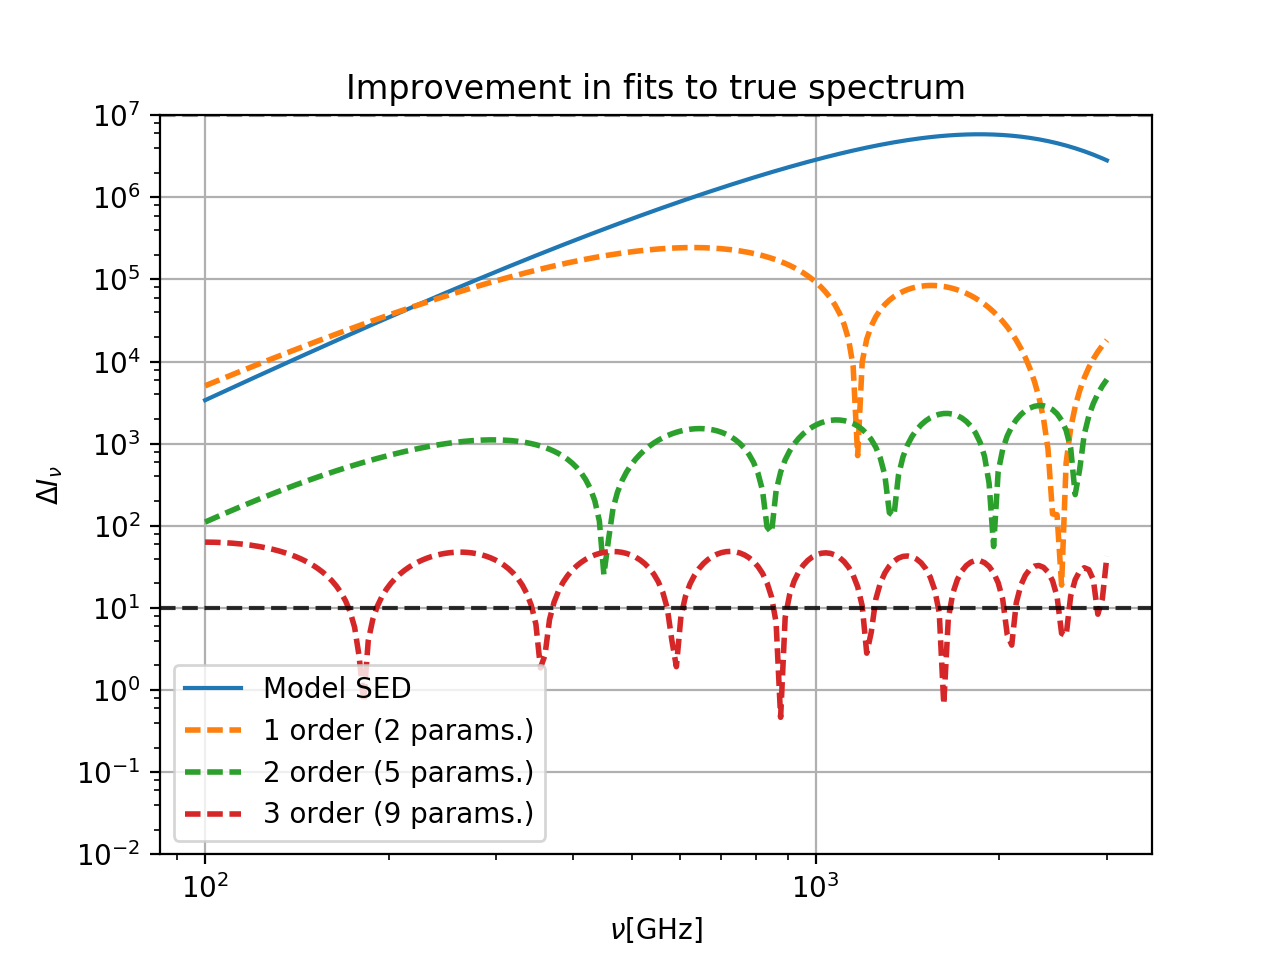

(0.01, 10000000.0)

In [82]:
figure()
title("Improvement in fits to true spectrum")
pllabel="Model SED"
plot(nu,Inu,label=pllabel)
pllabel="1 order (2 params.)"
plot(nu,abs(Inu-f_mbb1(nu,p2=fitp1[0],p3=fitp1[1])),"--",lw=2,label=pllabel)
pllabel="2 order (5 params.)"
plot(nu,abs(Inu-f_mbb2(nu,p2=fitp2[0],p3=fitp2[1],p22=fitp2[2], p23=fitp2[3],p33=fitp2[4])),"--",lw=2,label=pllabel)
pllabel="3 order (9 params.)"
plot(nu,abs(Inu-f_mbb3(nu,p2=fitp3[0],p3=fitp3[1],p22=fitp3[2], p23=fitp3[3],p33=fitp3[4],p222=fitp3[5],p223=fitp3[6],p233=fitp3[7],p333=fitp3[8])),"--",lw=2,label=pllabel)
semilogy()
loglog()
ylabel(r"$\Delta I_{\nu}$")
xlabel(r"$\nu$[GHz]")
#xticks([100,300,600,1000,3000],[100,300,600,1000,3000])
grid()
axhline(1e1,color="black",linestyle="dashed",alpha=0.8)
axhline(1e7,color="black",linestyle="dashed",alpha=0.4)
legend(loc=0)
ylim(1e-2,1e7)